In [1]:
import torch
import torch.nn.functional as F

import torchsde
import math
import matplotlib.pyplot as plt

from cfollmer.objectives import log_g, relative_entropy_control_cost
from cfollmer.sampler_utils import FollmerSDE
import numpy as np

from tqdm.notebook import tqdm

from torch import _vmap_internals

## Generating Toy 2D Dataset.

In [2]:
import torch
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

device = "cuda" if torch.cuda.is_available() else "cpu"
random_state = 170

X, y = make_blobs(n_samples=100,
                  cluster_std=[0.2, 0.2, 0.2],
                  random_state=random_state)

# X = X[y==0,:]
# y = y[y==0]
# # Scale data to have mean 0 and variance 1 
# # which is importance for convergence of the neural network
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data set into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=2)


X_train, X_test, y_train, y_test = \
    torch.tensor(X_train, dtype=torch.float32, device=device), \
    torch.tensor(X_test, dtype=torch.float32, device=device), \
    torch.tensor(y_train, dtype=torch.float32, device=device), \
    torch.tensor(y_test, dtype=torch.float32, device=device) 

In [3]:
y

array([0, 2, 2, 0, 0, 1, 1, 0, 2, 1, 1, 1, 0, 1, 0, 2, 1, 1, 1, 2, 2, 2,
       2, 2, 1, 1, 0, 2, 0, 1, 2, 0, 1, 2, 1, 0, 0, 0, 0, 0, 2, 0, 2, 0,
       0, 1, 2, 2, 0, 1, 2, 2, 1, 2, 0, 1, 2, 1, 0, 0, 1, 0, 0, 2, 0, 2,
       2, 1, 1, 1, 2, 0, 1, 0, 0, 0, 2, 1, 1, 1, 1, 1, 2, 1, 0, 0, 1, 2,
       2, 1, 2, 2, 1, 0, 2, 2, 0, 0, 0, 2])

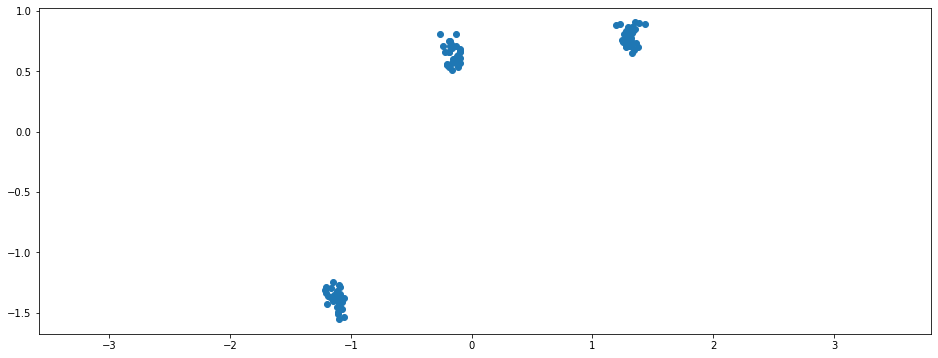

In [4]:
fig, ax1 = plt.subplots(1, 1, figsize=(16, 6))

ax1.plot(X_scaled[:, 0], X_scaled[:, 1], 
         linestyle='none', 
         marker='o')

ax1.axis('equal');

$$\DeclareMathOperator*{\argmin}{arg\,min}$$
$$\def\E{{\mathbb{E}}}$$
$$\def\rvu{{\mathbf{u}}}$$
$$\def\rvTheta{{\bm{\Theta}}}$$
$$\def\gU{{\mathcal{U}}}$$
$$\def\mX{{\mathbf{X}}}$$

## Controlled Schrodinger Follmer Sampler

The objevtive we are trying to implement is:

\begin{align}
  \mathbf{u}_t^{*}=  \argmin_{\rvu_t \in \mathcal{U}}\mathbb{E}\left[\frac{1}{2\gamma}\int_0^1||\rvu(t, \Theta_t)||^2 dt - \ln\left(\frac{ p(\mX | \Theta_1)p(\Theta_1)}{\mathcal{N}(\Theta_1|\mathbf{0}, \gamma \mathbb{I} )}\right)\right] \
\end{align}

Where:
\begin{align}
d\Theta_t = \rvu(t, \Theta_t)dt + \sqrt{\gamma} dB_t
\end{align}

To do so we use the EM discretisation.

In [5]:
def log_gaussian(x, mean=0):
    """
    Returns the density of x under the supplied gaussian. Defaults to
    standard gaussian N(0, I)
    :param x: (*) torch.Tensor
    :param mean: float or torch.FloatTensor with dimensions (*)
    :param logvar: float or torch.FloatTensor with dimensions (*)
    :return: (*) elementwise log density
    """
    
    log_norm_constant = -0.5 * np.log(2 * np.pi)
    
    var =  torch.tensor(0.2)
    logvar = torch.log(var)
    logvar = x.new(1).fill_(logvar)
    
    A = (x - mean) ** 2
    log_p = -0.5 * (logvar + A / logvar.exp())
    log_p = log_p + log_norm_constant
#     import pdb; pdb.set_trace()
    return log_p.sum(dim=-1)



def ln_prior(Θ, σ_w=0.7):
    """
    Prior for means in Bayesian GMM
    """
    return -0.5 * (Θ**2).sum(axis=1) / σ_w**2


def log_likelihood_single(μ, X, log=True, K=3):
    """
    :param X: design matrix (examples, features)
    :param mu: the component means (K, features)
    :param logvar: the component log-variances (K, features)
    :param log: return value in log domain?

    """
    
    n, d = X.shape
    # get feature-wise log-likelihoods (K, examples, features)
#     import pdb; pdb.set_trace()
    log_likelihoods = log_gaussian(
        X[None, :, :], # (1, examples, features)
        μ.reshape(K, d)[:, None, :], # (K, 1, features)
    )
    

    # sum over the feature dimension
    
    log_likelihoods = torch.logsumexp(log_likelihoods, dim=0) 

    return log_likelihoods.sum()


def log_likelihood(Θ, X, y=None, K=3):
    """
    batching the above (hopefully its right)
    """

    loss_ = lambda μ: log_likelihood_single(μ, X,K=K)
    
    batched_loss =  torch._vmap_internals.vmap(loss_)

    return batched_loss(Θ)

In [6]:
Δt=0.01
K = 3
t_size = int(math.ceil(1.0/Δt))
dim = K * 2

ts = torch.linspace(0, 1, t_size).to(device)
no_posterior_samples = 50

sde = FollmerSDE(dim, dim, no_posterior_samples, 1.0, device=device).to(device)
Θ_0 = torch.zeros((no_posterior_samples, dim)).to(device) # Θ_0 ~ δ_0

# Initial state y0, the SDE is solved over the interval [ts[0], ts[-1]].
# ys will have shape (t_size, batch_size, state_size)
ys = torchsde.sdeint(sde, Θ_0, ts, dt=Δt)

In [7]:
Θ_0.shape

torch.Size([50, 6])

In [8]:
relative_entropy_control_cost(sde, Θ_0, X_train, y_train, 
                              ln_prior, log_likelihood, γ=1.0, device=device)

C:\Users\vargf\AppData\Local\Temp/ipykernel_25376/1674092342.py:64: UserWarning: torch.vmap is an experimental prototype that is subject to change and/or deletion. Please use at your own risk. There may be unexpected performance cliffs due to certain operators not being implemented. To see detailed performance warnings please use `torch._C._debug_only_display_vmap_fallback_warnings(True) before the call to `vmap`.
  batched_loss =  torch._vmap_internals.vmap(loss_)


tensor(340.2701, device='cuda:0', grad_fn=<MeanBackward0>)

In [34]:
γ = 0.4
Δt=0.0009
t_size = int(math.ceil(1.0/Δt))
# print(t_size)
ts = torch.linspace(0, 1, t_size).to(device)
# print(ts)
sde = FollmerSDE(dim, dim, no_posterior_samples  , γ=γ, device=device).to(device)
optimizer = torch.optim.Adam(sde.μ.parameters(), lr=0.05, weight_decay =1)
#     optimizer = torch.optim.LBFGS(gpr.parameters(), lr=0.01)
losses = []
num_steps = 300
for i in tqdm(range(num_steps)):
    optimizer.zero_grad()

    if isinstance(optimizer, torch.optim.LBFGS):
        def closure():
            loss = relative_entropy_control_cost(
                sde, Θ_0.float(),
                X_train.float(), y_train.float(),
                ln_prior, log_likelihood, γ=γ
            )
            optimizer.zero_grad()
            loss.backward()
            return loss

        optimizer.step(closure)
        losses.append(closure().item())
    else:
        loss = relative_entropy_control_cost(
            sde, Θ_0,
            X_train, y_train,
            ln_prior, log_likelihood, γ=γ
        )
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        losses.append(loss.item())
torch.cuda.empty_cache()

  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\vargf\AppData\Local\Temp/ipykernel_25376/1674092342.py:64: UserWarning: torch.vmap is an experimental prototype that is subject to change and/or deletion. Please use at your own risk. There may be unexpected performance cliffs due to certain operators not being implemented. To see detailed performance warnings please use `torch._C._debug_only_display_vmap_fallback_warnings(True) before the call to `vmap`.
  batched_loss =  torch._vmap_internals.vmap(loss_)


In [35]:
losses

[285.0807800292969,
 276.9433898925781,
 280.5668029785156,
 289.2696533203125,
 235.57098388671875,
 154.003662109375,
 424.505615234375,
 106.29956817626953,
 117.8410873413086,
 136.12362670898438,
 111.92827606201172,
 120.8127670288086,
 96.63661193847656,
 111.44363403320312,
 111.24480438232422,
 86.48267364501953,
 92.92597198486328,
 83.15713500976562,
 88.2558364868164,
 84.52387237548828,
 89.31771087646484,
 92.32695007324219,
 85.3392333984375,
 85.76390075683594,
 96.33611297607422,
 87.63755798339844,
 86.51255798339844,
 82.96984100341797,
 84.13579559326172,
 75.00515747070312,
 78.36343383789062,
 81.76399993896484,
 80.9101333618164,
 87.13456726074219,
 88.1131591796875,
 79.062744140625,
 85.47350311279297,
 86.46533203125,
 81.20178985595703,
 81.74774169921875,
 85.93755340576172,
 76.66182708740234,
 91.6317367553711,
 79.5133056640625,
 79.3332290649414,
 86.59209442138672,
 83.9529800415039,
 83.65556335449219,
 81.94560241699219,
 87.76274871826172,
 86.01569

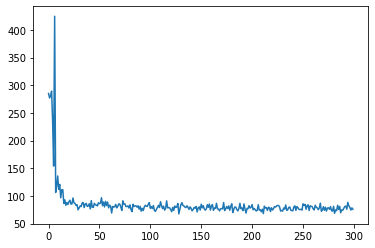

In [36]:
plt.plot(losses[:])

In [37]:
 torchsde.sdeint(sde, Θ_0, ts, method="euler", dt=Δt).shape

torch.Size([1112, 50, 6])

In [38]:
X_train.shape

torch.Size([80, 2])

In [39]:
torch.cuda.empty_cache()
Θ_1 = torchsde.sdeint(sde, Θ_0, ts, dt=Δt)[-1,...]
torch.cuda.empty_cache()

In [40]:
Θ_1 = Θ_1.reshape(50,K,2)

(array([ 7., 21., 14.,  7.,  2., 18., 40., 25., 14.,  2.]),
 array([-2.0703833 , -1.6715163 , -1.2726494 , -0.8737824 , -0.47491544,
        -0.07604849,  0.32281846,  0.7216854 ,  1.1205524 ,  1.5194193 ,
         1.9182863 ], dtype=float32),
 <a list of 10 Patch objects>)

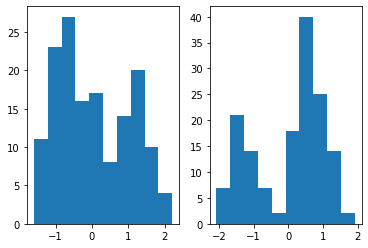

In [41]:
fig, (ax1,ax2) = plt.subplots(1,2)

ax1.hist(Θ_1[:,:,0].flatten().cpu().detach().numpy())
ax2.hist(Θ_1[:,:,1].flatten().cpu().detach().numpy())

In [42]:
Θ_1.mean(axis=0).reshape(K,2)

tensor([[ 1.2441,  0.6190],
        [-0.9988, -1.2929],
        [-0.1464,  0.7503]], device='cuda:0', grad_fn=<ReshapeAliasBackward0>)

In [43]:
Θ_1.shape

torch.Size([50, 3, 2])

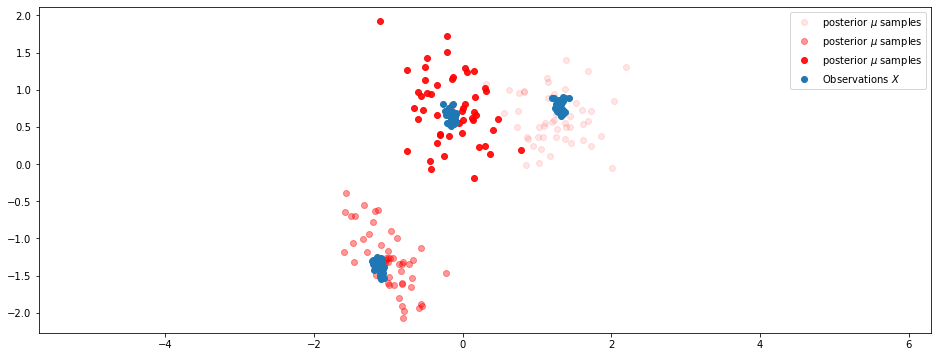

In [44]:
fig, ax_1 = plt.subplots(1, 1, figsize=(16, 6))
Θ_plot = Θ_1.cpu().detach() #.reshape(50*3,2)


for i in range(K):
    ax_1.plot(Θ_plot[:,i, 0], Θ_plot[:, i, 1], 
             linestyle='none', 
             marker='o', color="red", label="posterior $\mu$ samples", alpha= (i+1)**2 * 0.1)

ax_1.plot(X_scaled[:, 0], X_scaled[:, 1], 
         linestyle='none', 
         marker='o', label="Observations $X$")

ax_1.legend()
ax_1.axis('equal');